In [3]:
!pip install catboost

In [4]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
df = pd.read_csv('../data/telco_cleaned1.csv')

In [6]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [7]:
df.drop(columns=['customerID'], inplace=True)

In [8]:
X = df.drop(columns=['Churn'])
y = df['Churn']

In [9]:
cat_cols = X.select_dtypes(include='object').columns.tolist()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, stratify=y, random_state=42
)

In [11]:
model = CatBoostClassifier(
iterations=500,
learning_rate=0.05,
depth=6,
eval_metric='Accuracy',
cat_features=cat_cols,
verbose=100,
random_state=42
)

In [12]:
model.fit(X_train, y_train, cat_features=cat_cols, eval_set=(X_test, y_test))

0:	learn: 0.7786652	test: 0.7665011	best: 0.7665011 (0)	total: 220ms	remaining: 1m 49s
100:	learn: 0.8209088	test: 0.8076650	best: 0.8112136 (45)	total: 5.7s	remaining: 22.5s
200:	learn: 0.8283635	test: 0.8055358	best: 0.8112136 (45)	total: 11.5s	remaining: 17.1s
300:	learn: 0.8418530	test: 0.8019872	best: 0.8112136 (45)	total: 17.6s	remaining: 11.7s
400:	learn: 0.8505502	test: 0.8048261	best: 0.8112136 (45)	total: 23.7s	remaining: 5.84s
499:	learn: 0.8576500	test: 0.8034067	best: 0.8112136 (45)	total: 29.7s	remaining: 0us

bestTest = 0.8112136267
bestIteration = 45

Shrink model to first 46 iterations.


In [13]:
y_pred = model.predict(X_test)

In [14]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[949  86]
 [180 194]]
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1035
           1       0.69      0.52      0.59       374

    accuracy                           0.81      1409
   macro avg       0.77      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [15]:
import matplotlib.pyplot as plt

feature_importance = model.get_feature_importance()
feature_names = X.columns

In [16]:
top_idx = feature_importance.argsort()[-10:]

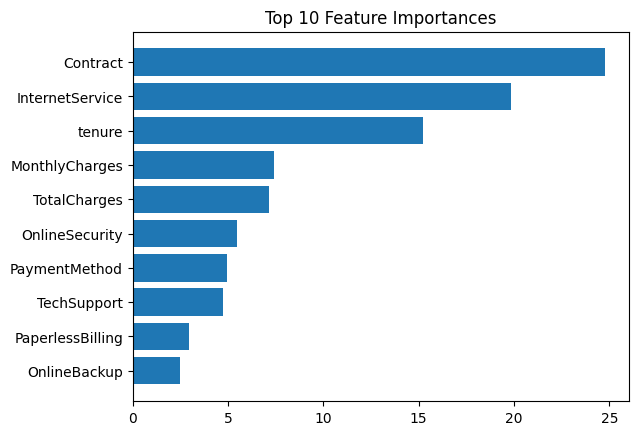

In [17]:
plt.barh(range(10), feature_importance[top_idx])
plt.yticks(range(10), [feature_names[i] for i in top_idx])
plt.title("Top 10 Feature Importances")
plt.show()

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from catboost import CatBoostClassifier
import numpy as np

In [19]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [20]:
f1_scores = []

In [21]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n Fold {fold+1}")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]


 Fold 1

 Fold 2

 Fold 3

 Fold 4

 Fold 5


In [22]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(
        iterations=300,
        learning_rate=0.05,
        depth=6,
        verbose=False,
        random_state=42,
        cat_features=cat_cols
    )

In [23]:

    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_val)

In [24]:
    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)
    print("F1-score (Churn=1):", round(f1, 4))

F1-score (Churn=1): 0.5511


In [25]:
print("\n Average F1-score across folds:", round(np.mean(f1_scores), 4))
print("\n Classification Report (last fold):")
print(classification_report(y_val, y_pred))


 Average F1-score across folds: 0.5511

 Classification Report (last fold):
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1034
           1       0.65      0.48      0.55       374

    accuracy                           0.79      1408
   macro avg       0.74      0.69      0.71      1408
weighted avg       0.78      0.79      0.78      1408



In [26]:
!pip install optuna

In [27]:
pip install "packaging<24" "pillow<11"

Note: you may need to restart the kernel to use updated packages.


In [28]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier

# Load data
df = pd.read_csv('../data/telco_cleaned1.csv')
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})
X = df.drop(columns=["Churn", "customerID"])
y = df["Churn"]
categorical_features = X.select_dtypes(include="object").columns.tolist()

# Define objective function for Optuna
def objective(trial):
    params = {
        "iterations": 300,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_state": 42,
        "verbose": False,
        "cat_features": categorical_features
    }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        f1_scores.append(f1_score(y_val, preds))

    return np.mean(f1_scores)

# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2025-06-02 14:08:01,274] A new study created in memory with name: no-name-14eff295-24e9-46e7-83db-6f424dbf2f5e
[I 2025-06-02 14:08:54,847] Trial 0 finished with value: 0.5802159811301291 and parameters: {'learning_rate': 0.08368212682423176, 'depth': 6, 'l2_leaf_reg': 1.1287039198459445, 'random_strength': 4.072387372575283e-05, 'bagging_temperature': 0.8846023876478949}. Best is trial 0 with value: 0.5802159811301291.
[I 2025-06-02 14:10:53,921] Trial 1 finished with value: 0.5550886255830031 and parameters: {'learning_rate': 0.11256769040914054, 'depth': 10, 'l2_leaf_reg': 8.991181922117011, 'random_strength': 1.6677846823088652e-08, 'bagging_temperature': 0.7007260082348535}. Best is trial 0 with value: 0.5802159811301291.
[I 2025-06-02 14:12:29,512] Trial 2 finished with value: 0.5727892455975027 and parameters: {'learning_rate': 0.06552027342665917, 'depth': 10, 'l2_leaf_reg': 8.162654855015862, 'random_strength': 1.172281636892066, 'bagging_temperature': 0.7591775107792722}. B

In [29]:
# Best parameters
print("\n✅ Best F1-score:", study.best_value)
print("\n📌 Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")


✅ Best F1-score: 0.5944405009485144

📌 Best hyperparameters:
learning_rate: 0.03845259726507681
depth: 5
l2_leaf_reg: 4.241282673873435
random_strength: 6.777303920176117
bagging_temperature: 0.4485623397225911


In [30]:
# Retrieve best parameters from study
best_params = study.best_params.copy()

# Add required static parameters
best_params.update({
    "iterations": 300,
    "random_state": 42,
    "verbose": False,
    "cat_features": categorical_features
})


In [31]:
final_model = CatBoostClassifier(**best_params)
final_model.fit(X, y)

In [32]:
y_pred = final_model.predict(X)
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
print("\nClassification Report:\n", classification_report(y, y_pred))

Confusion Matrix:
 [[4729  445]
 [ 893  976]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.88      5174
           1       0.69      0.52      0.59      1869

    accuracy                           0.81      7043
   macro avg       0.76      0.72      0.73      7043
weighted avg       0.80      0.81      0.80      7043

